The reviewers challenged us to revisit the statement that the AlphaFold prediction quality for _Spongilla_ was the same as for other species.

In [1]:
from tqdm import tqdm
import glob

import numpy as np
import pandas as pd

In [2]:
plddt = {}
for path in glob.glob("../data/alphafold_performance/*"):
    basename = path.split("/")[-1]
    species = basename.split(".")[0]
    tmp = pd.read_csv(path, sep="\t", index_col=0)
    plddt[species] = tmp["plddt"].T.values

In [3]:
genes = []
score = []
with np.load("../data/results/spongilla_plddt.npz") as spongilla:
    for gene in spongilla.keys():
        genes.append(gene)
        score.append(np.mean(spongilla[gene]))

plddt["S_lacustris"] = np.array(score)

In [4]:
for species, score in plddt.items():
    print(f"{species}: {np.mean(score)}")

A_thaliana: 76.22393314776092
M_musculus: 76.83108403554503
D_rerio: 77.01267466362071
S_cerevisiae: 77.06218951526964
H_sapiens: 75.10441887682073
D_discoideum: 72.2162702104969
C_elegans: 76.09296514024136
D_melanogaster: 75.47418361932716
S_lacustris: 71.38809554389019


To do goodness-of-fit tests it is important to know what sort of distribution we are analysing. We will use D'Agostino and Pearson's test to check if the pLDDT score distributions are normal. The null hypothesis is that they are from a normal distribution, so a small p-value means we can reject it.

In [4]:
import scipy.stats as stats
from scipy.stats import normaltest

In [5]:
print("Two-sided χ-squared probability for the hypothesis test (rounded to 10 decimals)")
for species, score in plddt.items():
    stat, pval = normaltest(score)
    print(f"{species}: {np.round_(pval, decimals=10)}")

Two-sided χ-squared probability for the hypothesis test (rounded to 10 decimals)
A_thaliana: 0.0
M_musculus: 0.0
D_rerio: 0.0
S_cerevisiae: 0.0
H_sapiens: 0.0
D_discoideum: 0.0
C_elegans: 0.0
D_melanogaster: 0.0
S_lacustris: 0.0


none of the distributions are normal; this means we are left with non-parametric distribution tests like the Kolmogorov-Smirnov.

In [6]:
from scipy.stats import ks_2samp

In [7]:
species = plddt.keys()
result = np.zeros((len(species), len(species)))

In [8]:
for i, s1 in enumerate(species):
    for j, s2 in enumerate(species):
        stat, pval = ks_2samp(plddt[s1], plddt[s2])
        result[i, j] = pval

In [9]:
ks_result = pd.DataFrame(result, columns=species, index=species)

In [10]:
ks_result

A_thaliana     M_musculus        D_rerio  S_cerevisiae  \
A_thaliana       1.000000e+00   6.934609e-13   9.114463e-18  7.262317e-19   
M_musculus       6.934609e-13   1.000000e+00   2.070102e-08  5.863687e-16   
D_rerio          9.114463e-18   2.070102e-08   1.000000e+00  4.857841e-19   
S_cerevisiae     7.262317e-19   5.863687e-16   4.857841e-19  1.000000e+00   
H_sapiens        5.750618e-12   5.731073e-34   8.699267e-45  6.808127e-22   
D_discoideum    9.016068e-113  2.383184e-159  1.086386e-182  3.284647e-74   
C_elegans        4.454955e-08   5.537467e-06   1.085280e-13  1.288430e-22   
D_melanogaster   1.026131e-23   6.251385e-24   2.567091e-39  2.306440e-12   
S_lacustris     1.648052e-254  1.329357e-215  4.784290e-287  4.903494e-81   

                    H_sapiens   D_discoideum      C_elegans  D_melanogaster  \
A_thaliana       5.750618e-12  9.016068e-113   4.454955e-08    1.026131e-23   
M_musculus       5.731073e-34  2.383184e-159   5.537467e-06    6.251385e-24   
D_rerio          8.699267e-45  1.086386e-182   1.085280e-13    2.567091e-39   
S_cerevisiae     6.808127e-22   3.284647e-74   1.288430e-22    2.306440e-12   
H_sapiens        1.000000e+00   1.030890e-58   1.705286e-21    8.108620e-11   
D_discoideum     1.030890e-58   1.000000e+00  2.050222e-114    4.987552e-62   
C_elegans        1.705286e-21  2.050222e-114   1.000000e+00    1.466712e-09   
D_melanogaster   8.108620e-11   4.987552e-62   1.466712e-09    1.000000e+00   
S_lacustris     4.824450e-129   3.228598e-15  1.278533e-145    6.907128e-69   

                  S_lacustris  
A_thaliana      1.648052e-254  
M_musculus      1.329357e-215  
D_rerio         4.784290e-287  
S_cerevisiae     4.903494e-81  
H_sapiens       4.824450e-129  
D_discoideum     3.228598e-15  
C_elegans       1.278533e-145  
D_melanogaster   6.907128e-69  
S_lacustris      1.000000e+00

This tells us that all of the distributions have easy-to-differentiate ECDFs. Let's plot them:

In [11]:
from matplotlib import pyplot as plt

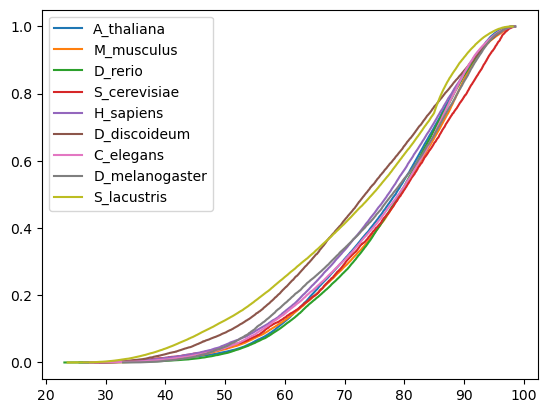

In [12]:
fig, ax = plt.subplots()
for s in species:
    x = np.sort(plddt[s])
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label=s)
    
ax.legend();

This is indeed the case. _Spongilla_ and _Dictyostelium_ differ even more from the other organisms, enough so that the naked eye can spot it. There is no overwhelming similarity in the profiles, however.

In [13]:
from scipy.stats import kruskal

In [14]:
result = np.zeros((len(species), len(species)))

In [15]:
for i, s1 in enumerate(species):
    for j, s2 in enumerate(species):
        stat, pval = kruskal(plddt[s1], plddt[s2])
        result[i, j] = pval

In [16]:
kruskal_result = pd.DataFrame(result, columns=species, index=species)

In [17]:
kruskal_result

A_thaliana     M_musculus        D_rerio   S_cerevisiae  \
A_thaliana       1.000000e+00   5.401098e-11   1.294740e-09   4.059266e-11   
M_musculus       5.401098e-11   1.000000e+00   3.243668e-01   9.471571e-03   
D_rerio          1.294740e-09   3.243668e-01   1.000000e+00   2.391935e-03   
S_cerevisiae     4.059266e-11   9.471571e-03   2.391935e-03   1.000000e+00   
H_sapiens        4.322773e-14   1.298086e-38   1.350664e-38   8.916050e-27   
D_discoideum    3.897159e-126  1.058769e-163  2.799068e-176   2.290830e-97   
C_elegans        4.104535e-01   1.906173e-07   9.242227e-06   3.716571e-09   
D_melanogaster   2.307912e-03   1.179170e-14   6.695887e-14   5.815376e-15   
S_lacustris     1.998652e-273   0.000000e+00   0.000000e+00  1.645357e-141   

                    H_sapiens   D_discoideum      C_elegans  D_melanogaster  \
A_thaliana       4.322773e-14  3.897159e-126   4.104535e-01    2.307912e-03   
M_musculus       1.298086e-38  1.058769e-163   1.906173e-07    1.179170e-14   
D_rerio          1.350664e-38  2.799068e-176   9.242227e-06    6.695887e-14   
S_cerevisiae     8.916050e-27   2.290830e-97   3.716571e-09    5.815376e-15   
H_sapiens        1.000000e+00   3.002254e-61   3.791151e-14    1.497413e-03   
D_discoideum     3.002254e-61   1.000000e+00  1.923321e-111    5.084089e-65   
C_elegans        3.791151e-14  1.923321e-111   1.000000e+00    2.288044e-03   
D_melanogaster   1.497413e-03   5.084089e-65   2.288044e-03    1.000000e+00   
S_lacustris     2.972335e-129   7.809348e-03  5.246039e-227   3.730213e-131   

                  S_lacustris  
A_thaliana      1.998652e-273  
M_musculus       0.000000e+00  
D_rerio          0.000000e+00  
S_cerevisiae    1.645357e-141  
H_sapiens       2.972335e-129  
D_discoideum     7.809348e-03  
C_elegans       5.246039e-227  
D_melanogaster  3.730213e-131  
S_lacustris      1.000000e+00